In [ ]:
#Install GPy
!pip install GPy

     |████████████████████████████████| 959 kB 4.9 MB/s 
     |████████████████████████████████| 71 kB 10.5 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565066 sha256=9676646b9df112a06c5816a050da5287a6d86d266f8be0278a75c3087e0c586f
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=ad828ebf226ed792b08e09fe9626908f0cbe46a947fdf8cc1cf725d3cf43eb75
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz


In [45]:
#Imports   
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import GPy
import numpy as np
import pandas as pd
import math
from scipy.optimize import minimize, minimize_scalar
from IPython.core.display import display
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
from matplotlib import pyplot as plt

In [ ]:
#Create Approximate Robust Prior (from Gu 2019) class
from paramz.domains import _REAL, _POSITIVE, _NEGATIVE
import weakref

class ApproxRef(GPy.core.parameterization.priors.Prior):
    """
    Implementation of the approx reference prior from Mengyang Gu (2019)
    """
    #Copied from Gamma
    domain = _POSITIVE
    _instances = []
    
    ##Create
    def __new__(cls, Cl, b, a=0.2):  # Singleton:
        if cls._instances:
            cls._instances[:] = [instance for instance in cls._instances if instance()]
            for instance in cls._instances:
                if instance().Cl == Cl and instance().b == b and instance().a == a:
                    return instance()
        newfunc = super(GPy.core.parameterization.priors.Prior, cls).__new__
        if newfunc is object.__new__:
            o = newfunc(cls)  
        else:
            o = newfunc(cls, Cl, b, a)            
        cls._instances.append(weakref.ref(o))
        return cls._instances[-1]()
    
    #Properties - Cl, a, b (table 4.1 of Gu)
    @property
    def Cl(self):
        return self._Cl
    
    @property
    def a(self):
        return self._a
    
    @property
    def b(self):
        return self._b
    
    def __init__(self, Cl, b, a):
        self._Cl = float(Cl)
        self._a = float(a)
        self._b = float(b)
    
    #String return
    def __str__(self):
        #return "JR({:.2g}, {:.2g}, {:.4g})".format(self.Cl[0], self.a, self.b)
        return "JR(CL:" + str(self.Cl) + ", {:.2g}, {:.4g})".format(self.a, self.b)
    
    #Summary return (NA)
    def summary(self):
        ret = {"Inverse range": 1. / self.b}
        return ret
    
    #Equation 4.1 of Gu theiss
    def lnpdf(self, x):
        #beta = np.exp(x)
        #Beta is 1/lengthscale
        beta = 1./x
        #Calculate T (the Cl.Bl part)
        t = np.multiply(self.Cl, beta)
        #Calculate 4.1a
        partI = -self.b*t
        partII = self.a*np.log(t)
        return partI + partII
    
    #Derivative - returns a vector?
    def lnpdf_grad(self, x):
        #beta = np.exp(x)
        #Beta is 1/lengthscale
        beta = 1./x
        #Calc t
        t = np.multiply(self.Cl, beta)
        #Return
        return (self.a*self.Cl/t - self.b*self.Cl)
    
    #randomvalues - don't use. Better to take mixture from betas calculated
    def rvs(self, n):
        return np.random.rand(n) 
    #Helper function to calculate C_l
    def calcCL(input_points, n_variables):
        return (np.max(input_points) - np.min(input_points))/math.pow(float(len(input_points)),1./float(n_variables))

In [ ]:
#Calculate R0 matrix - looks OK
def determineRO(input_matrix):
    #Initialise
    return np.abs(np.subtract.outer(input_matrix, input_matrix))
#Lower bound function - OK
def LB_func(guess, inputs, kernel):
    #Inputs is a list of arrays from RO
    #Hardcode tolerance
    tol =1.e16
    n_inputs = float(len(inputs[0]))
    proposal = np.exp(guess)/(np.exp(guess) + 1.)
    LB = np.log(-np.log(proposal)/[np.max(inputs[i]) for i in range(np.shape(inputs)[0])])
    R = np.ones(np.shape(inputs[0]))
    for it, nb in enumerate(kernel.parts):
        nb.lengthscale = 1./np.exp(LB[it])
        R = np.multiply(np.matrix(nb.K(inputs[it])), R)
    #Return value
    return math.pow(np.linalg.cond(R)-tol, 2)
#Calculate parameter Cl, eqn 4.1 in Gu thesis (l98 of rgasp.R), works
def calcCL(input_points, n_variables):
    return (np.max(input_points) - np.min(input_points))/math.pow(float(len(input_points)),1./float(n_variables))
#Step 4: Calculate the (log) marginal likelihood posterior for the robust prior, and its derivative for optimisation
#Functions
def calcB(input_points, n_variables, a = 0.2):
    return 1./math.pow(float(len(input_points)),1./float(n_variables)) * (a + n_variables)

In [ ]:
data = pd.read_pickle(r'taranaki_PDC-poi2.pk')
data[['orientation']] = np.deg2rad(data[['orientation']])
data.describe()

,height,run,utmx,utmy,vol,orientation,friction,lhsx,lhsy,lhsvol,lhsor,maxDp,maxKe
count,837.000000,837.000000,837.000000,8.370000e+02,8.370000e+02,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000
mean,1.678785,435.985663,246730.991087,5.646245e+06,5.345104e+06,1.550363,13.099369,0.506433,0.499052,0.529808,0.493496,3.460645,724.486434
std,2.658665,266.820231,104.752189,1.063299e+02,2.786087e+06,0.911821,4.510011,0.289298,0.277436,0.281423,0.290242,7.506200,1589.029487
min,0.000000,0.000000,246531.920713,5.646035e+06,1.048340e+05,0.001534,9.487826,0.000488,0.000488,0.000488,0.000488,0.000000,0.000000
25%,0.000000,209.000000,246643.019721,5.646161e+06,3.266260e+06,0.765456,10.355819,0.255371,0.266113,0.319824,0.243652,0.000000,0.000000
50%,0.000000,418.000000,246727.350718,5.646246e+06,5.480225e+06,1.547787,11.540633,0.514160,0.497559,0.543457,0.492676,0.000000,0.000000
75%,3.289372,650.000000,246814.754753,5.646331e+06,7.645850e+06,2.327049,13.638365,0.753418,0.730957,0.762207,0.740723,2.105851,416.602165
max,9.740523,1022.000000,246948.430520,5.646455e+06,9.995166e+06,3.140059,37.361273,0.999512,0.998535,0.999512,0.999512,39.178505,8425.765482


In [ ]:
#Initialise Kernel for lengthscale estimation
#UTM x and y
cUtm = GPy.kern.Matern32(input_dim=2, variance = 1.0, active_dims=[0,1], lengthscale= 1.0)
#Volume
cVol = GPy.kern.Matern32(input_dim = 1, variance=0.1, active_dims=[2], lengthscale=1.0)
#Orientation
cOr = GPy.kern.PeriodicMatern52(input_dim=1, variance=0.1, lengthscale=1.0, period=np.pi, n_freq=1, active_dims=[3]) 
#Combine
c = cVol * cUtm * cOr

In [ ]:
#Step 1: Calculate Cl - a scaling parameter - Mean of absolute distance
inputs = data[['utmx','utmy','vol', 'orientation']].values
cl = [calcCL(inputs[:,i], 4) for i in range(np.shape(inputs)[1])]
cl

[77.43617045107901, 77.93203342440933, 1838778.8813560004, 0.5835044671966656]

In [ ]:
#Step 2: Find LB 
#2a - get RO
R_zero = [determineRO(inputs[:,i]) for i in range(np.shape(inputs)[1])]
#2a - minimise LB_func
LBa = [minimize_scalar(LB_func, bounds=(-5.,12.), method='bounded', 
                      args=(R_zero, 
                            c)).x]
#2b - get prob
LBp = np.exp(LBa)/(np.exp(LBa)+1)
#2c - get LB
LB = np.log(-np.log(LBp)/[np.max(determineRO(inputs[:,i])) for i in range(np.shape(inputs)[1])])

In [ ]:
#Step 3: Set upper bound and initial value
initialBeta = 50.*np.exp(LB)
logInitialBeta = np.log(initialBeta)
upperBound = 1/np.exp(LB)
print("Upper bounds: " + str(upperBound)+"\n")
print("Initial values: " + str(1/initialBeta) +"\n")
print("Lower bounds: " + str(LB))

Upper bounds: [1.92729133e+04 1.93963276e+04 4.57649517e+08 1.45227107e+02]

Initial values: [3.85458267e+02 3.87926551e+02 9.15299035e+06 2.90454215e+00]

Lower bounds: [ -9.86645594  -9.87283903 -19.9416142   -4.97829877]


In [ ]:
#Create kernel for optimisation, using the initial bounds to define lenghtscale
cUtm = GPy.kern.Matern32(input_dim=2, variance = 1.0, active_dims=[0,1], ARD=True, lengthscale= [1./initialBeta[0], 1./initialBeta[1]])

cOr = GPy.kern.PeriodicMatern52(input_dim=1, variance = 1.0, lengthscale= 1./initialBeta[3],
                                    period=np.pi, n_freq = 1, active_dims=[3]) + GPy.kern.Bias(input_dim=1, 
                                                                                               variance=1, active_dims=[3])
cVol = GPy.kern.Matern32(input_dim=1, variance=1.0, 
                         active_dims=[2], lengthscale=1./initialBeta[2])
c = cVol * cUtm  * cOr

 /usr/local/lib/python3.7/dist-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [ ]:
#Calculate b
b = calcB(inputs, 4)

## Warped outputs

In [ ]:
#Create warping function
warping_fn = GPy.util.warping_functions.TanhFunction(n_terms=1)
warping_fn

warp_tanh.,value,constraints,priors
psi,"(1, 3)",{+ve},
d,1.0,+ve,


In [ ]:
#Create warped Gaussian process model
w = GPy.models.WarpedGP(X = data[['utmx','utmy','vol', 'orientation']].values, 
                        Y = data[['height']].values, #Without warping, log1p can be used, see Snelson (2001)
                        kernel = c,
                        warping_function = warping_fn)
w

gp.,value,constraints,priors
mul.Mat32.variance,1.0,+ve,
mul.Mat32.lengthscale,9152990.349140415,+ve,
mul.Mat32_1.variance,1.0,+ve,
mul.Mat32_1.lengthscale,"(2,)",+ve,
mul.sum.periodic_Matern52.variance,1.0,+ve,
mul.sum.periodic_Matern52.lengthscale,2.9045421453790237,+ve,
mul.sum.periodic_Matern52.period,3.141592653589793,+ve,
mul.sum.bias.variance,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,
warp_tanh.psi,"(1, 3)",{+ve},


In [ ]:
#Set Priors
a = 0.2
#UTM x and Y
w.kern.Mat32_1.lengthscale.set_prior(ApproxRef(cl[0], b, a))
w.kern.Mat32_1.variance.constrain_fixed(1.0)
#Orientation
w.kern.sum.periodic_Matern52.lengthscale.set_prior(ApproxRef(cl[3], b, a))
w.kern.sum.periodic_Matern52.period.constrain_fixed()
w.kern.sum.periodic_Matern52.variance.constrain_fixed(1.0)
w.kern.sum.bias.constrain_fixed(1.0)
#Volume
w.kern.Mat32.lengthscale.set_prior(ApproxRef(cl[2], b, a))
w.kern.Mat32.variance.constrain_fixed(1.0)
#Warping
#w.warp_tanh.d.constrain_fixed(1.0)
w

reconstraining parameters gp.mul.Mat32_1.lengthscale
reconstraining parameters gp.mul.sum.periodic_Matern52.lengthscale
reconstraining parameters gp.mul.Mat32.lengthscale
 /usr/local/lib/python3.7/dist-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1


gp.,value,constraints,priors
mul.Mat32.variance,1.0,+ve fixed,
mul.Mat32.lengthscale,9152990.349140415,+ve,"JR(CL:1838778.8813560004, 0.2, 0.7809)"
mul.Mat32_1.variance,1.0,+ve fixed,
mul.Mat32_1.lengthscale,"(2,)",+ve,"JR(CL:77.43617045107901, 0.2, 0.7809)"
mul.sum.periodic_Matern52.variance,1.0,+ve fixed,
mul.sum.periodic_Matern52.lengthscale,2.9045421453790237,+ve,"JR(CL:0.5835044671966656, 0.2, 0.7809)"
mul.sum.periodic_Matern52.period,3.141592653589793,+ve fixed,
mul.sum.bias.variance,1.0,+ve fixed,
Gaussian_noise.variance,1.0,+ve,
warp_tanh.psi,"(1, 3)",{+ve},


In [ ]:
#Optimise using SCG. Note lbfgs, or simplex can also be used 
w.optimize('scg', messages = True)

 /usr/local/lib/python3.7/dist-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /usr/local/lib/python3.7/dist-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1


 /usr/local/lib/python3.7/dist-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1
 /usr/local/lib/python3.7/dist-packages/GPy/util/warping_functions.py:142: RuntimeWarning:overflow encountered in cosh
 /usr/local/lib/python3.7/dist-packages/GPy/util/warping_functions.py:143: RuntimeWarning:overflow encountered in cosh
 /usr/local/lib/python3.7/dist-packages/GPy/util/warping_functions.py:144: RuntimeWarning:overflow encountered in cosh
 /usr/local/lib/python3.7/dist-packages/GPy/util/warping_functions.py:152: RuntimeWarning:overflow encountered in cosh
 /usr/local/lib/python3.7/dist-packages/GPy/util/warping_functions.py:153: RuntimeWarning:overflow encountered in cosh


[Text(0, 0, '0.0'),
 Text(0, 0, '0.5'),
 Text(0, 0, '1.0'),
 Text(0, 0, '2.5'),
 Text(0, 0, '5.0'),
 Text(0, 0, '10.0')]

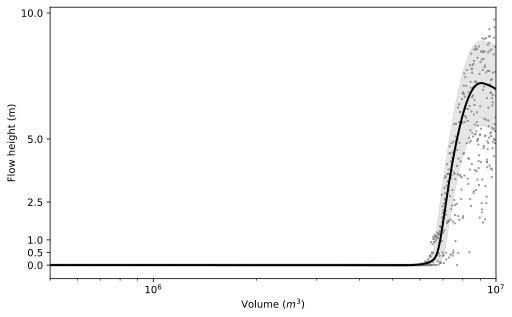

In [53]:
#Plot the emulator slice
fig, axes = plt.subplots(1,1)
w.plot_data(ax = axes, visible_dims = [2], marker = '.', color = 'grey', s = 2)
w.plot_confidence(ax = axes, fixed_inputs = [(0,246740.), (1,5646305.), (3, 2.04)], plot_limits=[5.e5, 1.e7], plot_raw = False, label = None, color = 'grey')
w.plot_mean(ax = axes, fixed_inputs = [(0,246740.), (1,5646305.), (3, 2.04)], plot_limits=[5.e5, 1.e7], color = 'k', label = 'Mean')
axes.set_xlabel(r'Volume ($m^{3}$)')
axes.set_xticks([1.e5, 5.e5, 1.e6, 2.5e6, 5.e6, 1.e7])
axes.set_xticklabels([r'1.0 $\times 10^{5}$',
                        r'5.0 $\times 10^{5}$',
                        r'1.0 $\times 10^{6}$',
                        r'2.5 $\times 10^{6}$',
                        r'5.0 $\times 10^{6}$',
                        #r'7.5 $\times 10^{6}$',
                        r'1.0 $\times 10^{7}$',
                       ]
  )
axes.set_xlim([5e5, 1.e7])
axes.set_xscale('log')
axes.set_ylabel('Flow height (m)')
axes.set_yticks([0.,0.5,1.0,2.5, 5., 10.0])
axes.set_yticklabels(['0.0','0.5','1.0','2.5','5.0', '10.0'])

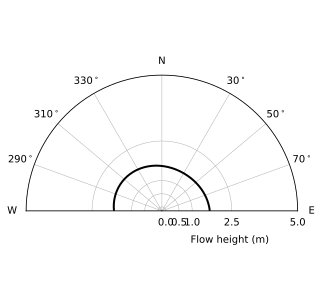

In [ ]:
ventLocation = [(0,246740.), (1,5646305.)] #N,E location of vent 
#Plot slice of emulator with orientation
fig, axes = plt.subplots(1,1, subplot_kw=dict(projection='polar'))
w.plot_mean(ax=axes,fixed_inputs = [ventLocation[0], ventLocation[1], (2, 7.e6)], color = 'k', linestyle = '-')
axes.set_ylim([-0.15,5.0])
axes.yaxis.set_label_coords(0.75, 0.125)
axes.set_ylabel('Flow height (m)', rotation = 0)
axes.set_yticks([0.,0.5,1.0,2.5, 5.])
axes.set_yticklabels(['0.0','0.5','1.0','2.5','5.0'])
axes.set_thetagrids((0, 20, 40, 60, 90, 120, 140, 160, 180), labels = ('E', '70$^\circ$', '50$^\circ$', '30$^\circ$', 'N', '330$^\circ$', '310$^\circ$', '290$^\circ$', 'W'))
axes.grid(linewidth = 0.5)
axes.set_thetamin(0)
axes.set_thetamax(180)

### LOO assesment

In [ ]:
#Create some constants file
ventLocation = [(0,246740.), (1,5646305.)] #N,E location of vent 
maxVentRadius = 210.

In [ ]:
def calcLooMu(emulator):
  g = emulator.posterior.woodbury_vector
  cdiag = np.diag(emulator.posterior.woodbury_inv)[:, None]
  mu = emulator.Y - g/cdiag
  return mu

def calcLooVar(emulator):
  var = 1/np.diag(emulator.posterior.woodbury_inv)[:, None]
  return var

In [ ]:
loo_error = w.inference_method.LOO(w.kern, w.X, w.Y, w.likelihood, w.posterior)

In [ ]:
u = calcLooMu(w)
var = calcLooVar(w)
loo = np.c_[u, var, w.Y]

In [ ]:
looSorted = loo[loo[:,0].argsort()]
withinConfidence = np.logical_and(looSorted[:,0]-2.0*np.sqrt(looSorted[:,1])>looSorted[:,2],
                                  looSorted[:,0]+2.0*np.sqrt(looSorted[:,1])>looSorted[:,2])

Text(0, 0.5, 'Emulated height (m)')

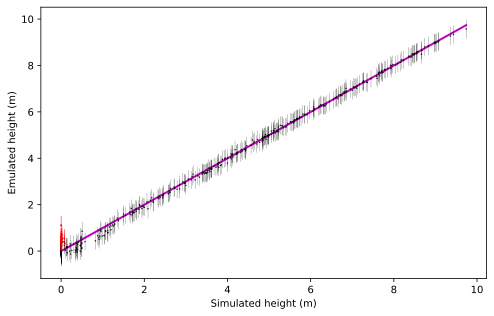

In [ ]:
#Plotting
fig, axes = plt.subplots(1,1)
axes.errorbar(looSorted[withinConfidence,2], looSorted[withinConfidence,0], yerr = 2.0*np.sqrt(looSorted[withinConfidence, 1]), fmt='.', markersize = 2.0, c = 'r', elinewidth = 0.5, zorder = 7)
axes.errorbar(looSorted[~withinConfidence,2], looSorted[~withinConfidence,0], yerr = 2.0*np.sqrt(looSorted[~withinConfidence, 1]), fmt='.', c = 'k', markersize = 1.0, elinewidth = 0.2)
axes.plot(w.Y, w.Y, color= 'm', linewidth = 2, zorder = 0)
axes.set_xlabel('Simulated height (m)')
axes.set_ylabel('Emulated height (m)')

## Hazard assessment

In [ ]:
#Install powerlaw package
!pip install powerlaw

In [ ]:
import powerlaw
import statsmodels.distributions.empirical_distribution as smd

 /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
#Read Hartnett et al dome data
DomeData = pd.read_csv('DomeData.csv', names = ("ID",
                                       "Location",
                                       "Date",
                                       "Comp",
                                       "DepVol",
                                       "Vol",
                                       "proportion"),
                       dtype = {"ID":np.int32,
                                "DepVol":np.float32,
                                "Vol":np.float32,
                                "proportion":np.float32},
                       header = 0)
DomeData = DomeData.drop([225])
DomeData = DomeData[DomeData.Comp == 'A']

Calculating best minimal value for power law fit


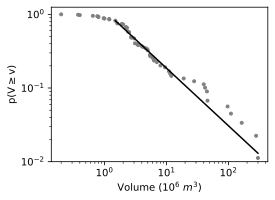

In [ ]:
fit = powerlaw.Fit(DomeData['DepVol'].dropna())
fig, axes = plt.subplots(1,1, figsize = (4,3))

axes.scatter(fit.ccdf(original_data=True)[0], fit.ccdf(original_data=True)[1], marker = '.', color = 'grey', zorder = 1)
axes.set_xscale('log')
axes.set_yscale('log')
#fit.power_law.plot_ccdf(color='k', ax=axes, zorder = 1)

x_pl = np.linspace(fit.xmin, np.max(fit.data), len(fit.data))
#add the scaling paramer
axes.plot(x_pl, fit.power_law.ccdf(x_pl) * 0.8202247, color = 'k')

#axes.set_xlim(fit.xmin)
axes.set_ylim(bottom = 10**-2)
        
axes.set_ylabel('p(V$\geq$v)')
axes.set_xlabel(r'Volume ($10^6$ $m^{3}$)')
fig.tight_layout()

### Monte-Carlo sampling

In [ ]:
def polarLocation(polar, radius):
    return np.array([np.sqrt(polar[:,0])*radius, polar[:,1]*(2.*np.pi)], order = 'F')
def getUTMXY(polar, vent):
    utmx = vent[0]+(polar[0]*np.cos(polar[1]))
    utmy = vent[1]+(polar[0]*np.sin(polar[1]))
    return utmx, utmy

In [55]:
#Create 10,000 draws of input conditions in U(UTM x/y, orientation) and power-law(volume)
nsamples = 10000
ventLocation = [246740.,5646305.]

input_sample_clip = np.zeros((nsamples, 4))

input_sample_clip[:, 0], input_sample_clip[:, 1]  = getUTMXY((np.sqrt(np.random.uniform(0,1,nsamples)*maxVentRadius),np.random.uniform(0,1,nsamples)*(2*np.pi)), ventLocation)
input_sample_clip[:, 2] = np.minimum(fit.power_law.generate_random(nsamples), 10.) * 10**6
input_sample_clip[:, 3] = np.random.uniform(0, np.pi, nsamples)

In [56]:
#Sample the posteior of the emulator (10 draws)
ndraws = 10
posterior_predict = np.zeros((nsamples, 1, ndraws))
posterior_predict = w.posterior_samples(input_sample_clip, size=ndraws)

 /usr/local/lib/python3.7/dist-packages/GPy/core/gp.py:614: RuntimeWarning:covariance is not positive-semidefinite.


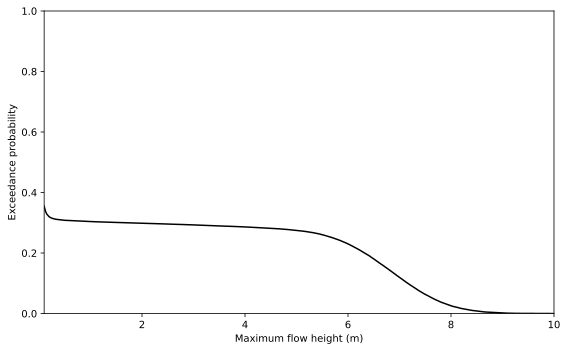

In [58]:
#Plot the ecdf
fig, axes = plt.subplots(1,1)
#Take the ECDF function of the posterior prediction, needs to be of the warping function.
ecdf_mean = smd.ECDF(w.warping_function.f_inv(posterior_predict).flatten())
axes.plot(ecdf_mean.x, 1-ecdf_mean.y, color = 'k')
axes.set_ylim(0,1.0)
axes.set_xlim(0.1, 10.0)
axes.set_ylabel('Exceedance probability')
axes.set_xlabel('Maximum flow height (m)')
fig.tight_layout()